In [4]:
pip install torchbnn

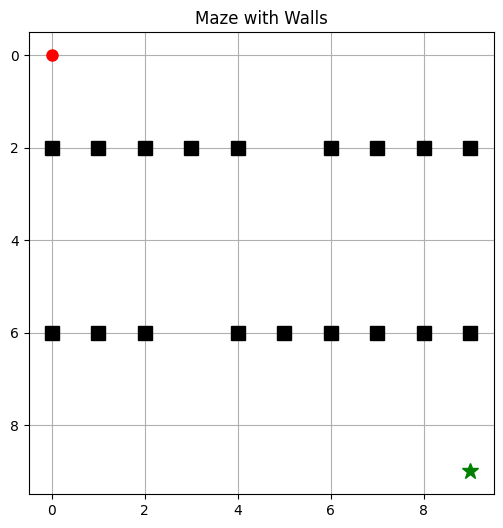

Episode 0: Steps=1409, Best=1409
Episode 1: Steps=275, Best=275
Episode 2: Steps=450, Best=275
Episode 3: Steps=982, Best=275
Episode 4: Steps=978, Best=275
Episode 5: Steps=1998, Best=275
Episode 6: Steps=388, Best=275
Episode 7: Steps=1811, Best=275
Episode 8: Steps=1010, Best=275
Episode 9: Steps=2008, Best=275
Episode 10: Steps=856, Best=275
Episode 11: Steps=463, Best=275
Episode 12: Steps=385, Best=275
Episode 13: Steps=826, Best=275
Episode 14: Steps=184, Best=184
Episode 15: Steps=510, Best=184
Episode 16: Steps=378, Best=184
Episode 17: Steps=531, Best=184
Episode 18: Steps=857, Best=184
Episode 19: Steps=661, Best=184
Episode 20: Steps=2529, Best=184
Episode 21: Steps=1283, Best=184
Episode 22: Steps=398, Best=184
Episode 23: Steps=2756, Best=184
Episode 24: Steps=909, Best=184
Episode 25: Steps=581, Best=184
Episode 26: Steps=589, Best=184
Episode 27: Steps=879, Best=184
Episode 28: Steps=340, Best=184
Episode 29: Steps=260, Best=184
Episode 30: Steps=537, Best=184
Episode 3

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchbnn as bnn
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

class Maze:
    def __init__(self, size=10):
        self.size = size
        self.grid = np.zeros((size, size))
        self.goal = (size-1, size-1)
        self.walls = self._create_walls()  # Add walls
        self.reset()

    def _create_walls(self):
        """Create horizontal walls to make a snakelike path"""
        walls = set()
        # Add horizontal walls at rows 2 and 6, leaving openings
        for y in range(self.size):
            if y != 5:  # Leave an opening at column 5
                walls.add((2, y))  # First horizontal wall
            if y != 3:  # Leave an opening at column 3
                walls.add((6, y))  # Second horizontal wall
        return walls

    def reset(self):
        self.agent_pos = (0, 0)
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos
        new_x, new_y = x, y

        if action == 0 and x > 0:           new_x -= 1  # Up
        elif action == 1 and y < self.size-1: new_y += 1  # Right
        elif action == 2 and x < self.size-1: new_x += 1  # Down
        elif action == 3 and y > 0:           new_y -= 1  # Left

        # Check for wall collisions
        if (new_x, new_y) not in self.walls:
            self.agent_pos = (new_x, new_y)

        done = (self.agent_pos == self.goal)
        reward = 1 if done else -0.01
        return self.agent_pos, reward, done

    def render(self):
        """Visualize maze with walls"""
        plt.figure(figsize=(6,6))

        # Draw walls
        for (x, y) in self.walls:
            plt.plot(y, x, 'ks', markersize=10)  # Black squares for walls

        # Draw agent and goal
        plt.plot(self.agent_pos[1], self.agent_pos[0], 'ro', markersize=8)
        plt.plot(self.goal[1], self.goal[0], 'g*', markersize=12)

        plt.xlim(-0.5, self.size-0.5)
        plt.ylim(-0.5, self.size-0.5)
        plt.gca().invert_yaxis()  # To match matrix coordinates
        plt.title("Maze with Walls")
        plt.grid(True)
        plt.show()

class BayesianDQN(torch.nn.Module):
    def __init__(self, state_dim=2, action_dim=4):
        super().__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=state_dim, out_features=32)
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def train_and_animate(maze, episodes=500, early_stop=True):
    model = BayesianDQN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = bnn.BKLLoss(reduction='mean', last_layer_only=False)

    uncertainty_history = []
    episode_metrics = []
    best_steps = float('inf')
    patience = 10
    no_improve = 0

    for ep in range(episodes):
        state = maze.reset()
        done = False
        steps = 0

        while not done:
            state_tensor = torch.FloatTensor(state)
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()
            next_state, reward, done = maze.step(action)

            target = reward + 0.99 * torch.max(model(torch.FloatTensor(next_state)))
            loss = torch.nn.MSELoss()(q_values[action], target) + criterion(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            steps += 1
            state = next_state

        if early_stop:
            if steps < best_steps:
                best_steps = steps
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                print(f"Early stopping at episode {ep} (no improvement for {patience} episodes)")
                break

        if ep % 1 == 0:  # Capture every episode for animation
            uncertainty_map = generate_uncertainty_map(model, maze)
            uncertainty_history.append(uncertainty_map)
            episode_metrics.append((ep, steps, best_steps))
            print(f"Episode {ep}: Steps={steps}, Best={best_steps}")

    return create_animation(uncertainty_history, episode_metrics, maze)

def generate_uncertainty_map(model, maze):
    uncertainty_map = np.zeros((maze.size, maze.size))
    for x in range(maze.size):
        for y in range(maze.size):
            if (x, y) in maze.walls:
                uncertainty_map[x, y] = -1  # Special value for walls
            else:
                state = torch.FloatTensor([x, y])
                q_samples = [model(state).detach().numpy() for _ in range(10)]
                uncertainty_map[x, y] = np.std(q_samples, axis=0).mean()
    return uncertainty_map

def create_animation(uncertainty_history, episode_metrics, maze):
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.close()

    # Create initial plot with walls
    masked_data = np.ma.masked_where(uncertainty_history[0] == -1, uncertainty_history[0])
    im = ax.imshow(masked_data, cmap='hot', vmin=0, vmax=1)

    # Add wall visualization
    wall_x, wall_y = zip(*maze.walls) if maze.walls else ([], [])
    ax.plot(wall_y, wall_x, 'ks', markersize=10, label='Walls')

    cbar = fig.colorbar(im, ax=ax, label='Uncertainty (Std Dev)')
    title = ax.set_title(f'Episode {episode_metrics[0][0]}\nSteps: {episode_metrics[0][1]}, Best: {episode_metrics[0][2]}')
    ax.legend()

    def update(frame):
        masked_data = np.ma.masked_where(uncertainty_history[frame] == -1, uncertainty_history[frame])
        im.set_array(masked_data)
        title.set_text(f'Episode {episode_metrics[frame][0]}\nSteps: {episode_metrics[frame][1]}, Best: {episode_metrics[frame][2]}')
        return im, title

    ani = FuncAnimation(
        fig,
        update,
        frames=len(uncertainty_history),
        interval=300,
        blit=True
    )

    return HTML(ani.to_jshtml())

if __name__ == "__main__":
    maze = Maze(size=10)
    maze.render()  # Show the maze layout first
    animation = train_and_animate(maze)
    display(animation)